In [ ]:
%pip install transformers torch scikit-learn pandas numpy matplotlib seaborn

In [ ]:
%pip install sentence_transformers

In [ ]:
%pip install --upgrade torch

In [1]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from torch.utils.data import DataLoader
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using device: cuda


In [2]:
#LOADING THE DATAFILE
# Load the dataset with correct delimiter
df = pd.read_csv('CourseworkDataset5.csv', delimiter=';')

# Clean column names (remove any extra spaces)
df.columns = df.columns.str.strip()

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nClass distribution:")
print(df['Class/ASD'].value_counts())
print(f"Percentage distribution:")
print(df['Class/ASD'].value_counts(normalize=True) * 100)
print(f"\nAQ-10 Score distribution:")
print(df['result'].value_counts().sort_index())

# Check for missing values
print(f"\nMissing values:")
print(df.isnull().sum())

# Display first few narratives
print("\nSample narratives:")
for i in range(3):
    print(f"\nPatient {i+1} (Class: {df.iloc[i]['Class/ASD']}, AQ-10: {df.iloc[i]['result']}):")
    print(df.iloc[i]['Narrative'][:200] + "...")

Dataset shape: (704, 23)

Column names: ['Patient_ID', 'A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender', 'ethnicity', 'jaundice', 'austim', 'contry_of_res', 'used_app_before', 'result', 'age_desc', 'relation', 'Class/ASD', 'Narrative']

Class distribution:
Class/ASD
NO     515
YES    189
Name: count, dtype: int64
Percentage distribution:
Class/ASD
NO     73.153409
YES    26.846591
Name: proportion, dtype: float64

AQ-10 Score distribution:
result
0.0      14
1.0      33
2.0      74
3.0     110
4.0     131
5.0      83
6.0      70
7.0      57
8.0      55
9.0      47
10.0     30
Name: count, dtype: int64

Missing values:
Patient_ID         0
A1_Score           0
A2_Score           0
A3_Score           0
A4_Score           0
A5_Score           0
A6_Score           0
A7_Score           0
A8_Score           0
A9_Score           0
A10_Score          0
age                2
gender             0
ethnicity    

In [3]:
#DATA PREPROCESSING
# Handle any data type issues
numeric_columns = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 
                   'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 
                   'age', 'result']

for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Remove any rows with missing narratives or class labels
df_clean = df.dropna(subset=['Narrative', 'Class/ASD'])
print(f"Rows after removing missing narratives/labels: {len(df_clean)}")

# Prepare features and labels
X = df_clean['Narrative'].values
y = df_clean['Class/ASD'].map({'YES': 1, 'NO': 0}).values

# Get AQ-10 scores for comparison
aq10_scores = df_clean['result'].values

# Check class balance
print(f"\nClass distribution after cleaning:")
print(f"NO ASD: {sum(y == 0)} ({sum(y == 0)/len(y)*100:.1f}%)")
print(f"ASD: {sum(y == 1)} ({sum(y == 1)/len(y)*100:.1f}%)")

# Split the data
X_train, X_test, y_train, y_test, aq10_train, aq10_test = train_test_split(
    X, y, aq10_scores, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Training set class distribution: NO={sum(y_train == 0)}, YES={sum(y_train == 1)}")
print(f"Test set class distribution: NO={sum(y_test == 0)}, YES={sum(y_test == 1)}")

Rows after removing missing narratives/labels: 704

Class distribution after cleaning:
NO ASD: 515 (73.2%)
ASD: 189 (26.8%)

Training set size: 563
Test set size: 141
Training set class distribution: NO=412, YES=151
Test set class distribution: NO=103, YES=38


In [4]:
#TEST/VAL/TRAIN SPLIT
#First split: separate test set (10%)
X_temp, X_test, y_temp, y_test, aq10_temp, aq10_test = train_test_split(
    X, y, aq10_scores, 
    test_size=0.10, 
    random_state=42, 
    stratify=y
)

# Second split: separate train and validation from temp (80% train, 10% val from original)
# Since temp is 90% of original, we need 10/90 = 0.111 to get 10% validation
X_train, X_val, y_train, y_val, aq10_train, aq10_val = train_test_split(
    X_temp, y_temp, aq10_temp, 
    test_size=0.111, 
    random_state=42, 
    stratify=y_temp
)

# Print split information
print(f"Dataset split:")
print(f"Total samples: {len(X)}")
print(f"Training set: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

# Verify class distribution in each set
print(f"\nClass distribution per set:")
print(f"Training - NO ASD: {sum(y_train == 0)}, ASD: {sum(y_train == 1)}")
print(f"Validation - NO ASD: {sum(y_val == 0)}, ASD: {sum(y_val == 1)}")
print(f"Test - NO ASD: {sum(y_test == 0)}, ASD: {sum(y_test == 1)}")

# Verify proportions are maintained
print(f"\nASD percentage per set:")
print(f"Training: {sum(y_train == 1)/len(y_train)*100:.1f}%")
print(f"Validation: {sum(y_val == 1)/len(y_val)*100:.1f}%")
print(f"Test: {sum(y_test == 1)/len(y_test)*100:.1f}%")

Dataset split:
Total samples: 704
Training set: 562 (79.8%)
Validation set: 71 (10.1%)
Test set: 71 (10.1%)

Class distribution per set:
Training - NO ASD: 411, ASD: 151
Validation - NO ASD: 52, ASD: 19
Test - NO ASD: 52, ASD: 19

ASD percentage per set:
Training: 26.9%
Validation: 26.8%
Test: 26.8%


In [11]:
# Check transformers version
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification
print(f"Transformers version: {transformers.__version__}")

import torch.nn as nn  

model_name = "mental/mental-bert-base-uncased"
print(f"Loading {model_name}…")

# put *all* hyper-parameters (incl. num_labels) inside the config
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=3,                       # <-- moved here
    hidden_dropout_prob=0.50,
    attention_probs_dropout_prob=0.50,
    classifier_dropout=0.50,
)

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    config=config
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model loaded with enhanced dropout (0.4)")
print(f"Parameters: {sum(p.numel() for p in model.parameters())/1e6:.1f} M")


def tokenize_function(texts):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=512)

class NarrativeDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

print("Tokenizing narratives…")
train_encodings = tokenize_function(X_train.tolist())
val_encodings   = tokenize_function(X_val.tolist())
test_encodings  = tokenize_function(X_test.tolist())

train_dataset = NarrativeDataset(train_encodings, y_train)
val_dataset   = NarrativeDataset(val_encodings, y_val)
test_dataset  = NarrativeDataset(test_encodings, y_test)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=8, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=8, shuffle=False)

print(f"Data loaders created – Batches: "
      f"Train={len(train_loader)}, Val={len(val_loader)}, Test={len(test_loader)}")


Transformers version: 4.52.4
Loading mental/mental-bert-base-uncased…


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at mental/mental-bert-base-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded with enhanced dropout (0.4)
Parameters: 109.5 M
Tokenizing narratives…
Data loaders created – Batches: Train=141, Val=9, Test=9


In [12]:
from torch.utils.data import DataLoader
import torch.nn.functional as F
import os, json, pandas as pd, numpy as np
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight

save_dir = "outputs"
os.makedirs(save_dir, exist_ok=True)

# Calculate class weights (for CrossEntropyLoss) – only needed for imbalanced data
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float, device=device)
print(f"Class weights: {class_weights}")

# Use class weights in the loss function
loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)

# Setup optimizer & scheduler
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=3e-6,              
    weight_decay=0.05     # tuned higher for regularisation
)
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',           # we now minimise validation loss
    factor=0.5,
    patience=3
)

# Training config
epochs = 30
best_val_accuracy = 0
best_val_loss = float('inf')
patience = 7
patience_counter = 0
min_delta = 0.001

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    train_correct = 0
    train_total = 0

    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} - Training')
    for batch_idx, batch in enumerate(progress_bar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Optional: augment input text for additional regularisation
        # If you want, augment X_train *before* creating DataLoader

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        predictions = torch.argmax(outputs.logits, dim=-1)
        train_correct += (predictions == labels).sum().item()
        train_total += labels.size(0)
        total_train_loss += loss.item()

        progress_bar.set_postfix({
            'loss': loss.item(), 
            'acc': train_correct/train_total
        })

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = train_correct / train_total

    # Validation phase
    model.eval()
    total_val_loss = 0
    val_correct = 0
    val_total = 0
    val_predictions_all = []
    val_labels_all = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} - Validation'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            predictions = torch.argmax(outputs.logits, dim=-1)
            val_correct += (predictions == labels).sum().item()
            val_total += labels.size(0)
            total_val_loss += loss.item()

            val_predictions_all.extend(predictions.cpu().numpy())
            val_labels_all.extend(labels.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = val_correct / val_total

    # Update learning rate based on validation **loss** (not accuracy)
    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_accuracy)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_accuracy)
    history['lr'].append(current_lr)

    # Calculate additional metrics for overfitting detection
    overfitting_score = train_accuracy - val_accuracy
    loss_ratio = avg_val_loss / avg_train_loss if avg_train_loss > 0 else 1

    print(f"\nEpoch {epoch+1} Results:")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
    print(f"Learning Rate: {current_lr:.2e}")
    print(f"Overfitting Score: {overfitting_score:.4f} (train-val gap)")
    print(f"Loss Ratio (val/train): {loss_ratio:.2f}")

    improved = False
    if avg_val_loss < best_val_loss - min_delta:
        best_val_loss = avg_val_loss
        best_val_accuracy = val_accuracy
        patience_counter = 0
        improved = True
        # Save all artefacts!
        model.load_state_dict(model.state_dict())  # ensure current weights
        model.save_pretrained(save_dir)
        tokenizer.save_pretrained(save_dir)
        torch.save(model.state_dict(), os.path.join(save_dir, "best_weights.bin"))
        np.save(os.path.join(save_dir, "val_preds.npy"),  np.array(val_predictions_all))
        np.save(os.path.join(save_dir, "val_labels.npy"), np.array(val_labels_all))
        pd.DataFrame(history).to_csv(os.path.join(save_dir, "history.csv"), index=False)
        with open(os.path.join(save_dir, "history.json"), "w") as f:
            json.dump(history, f, indent=2)
        config.save_pretrained(save_dir)
        print(f"\nSaved all artefacts to {os.path.abspath(save_dir)}")
        print(f"✓ New best validation loss: {best_val_loss:.4f}")
    else:
        patience_counter += 1
        print(f"✗ No improvement. Patience: {patience_counter}/{patience}")

    if overfitting_score > 0.15:
        print("⚠️ Warning: Significant overfitting detected (gap > 0.15)")

    if loss_ratio > 1.5:
        print("⚠️ Warning: Validation loss significantly higher than training loss")

    if epoch > 5 and avg_val_loss > history['val_loss'][-2]:
        print("⚠️ Warning: Validation loss is increasing")
        
    if patience_counter >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        print(f"Best validation loss: {best_val_loss:.4f}")
        break

    if current_lr < 1e-7:
        print(f"\nStopping: Learning rate too small ({current_lr:.2e})")
        break

    print("-"*60)

# Optional: Load best model after training (for immediate eval)
model.load_state_dict(torch.load(os.path.join(save_dir, "best_weights.bin")))
print(f"\nLoaded best model with validation loss: {best_val_loss:.4f}")

Class weights: tensor([0.6837, 1.8609], device='cuda:0')


Epoch 1/30 - Validation: 100%|██████████| 9/9 [00:00<00:00, 19.66it/s]



Epoch 1 Results:
Train Loss: 0.7601, Train Acc: 0.6922
Val Loss: 0.8105, Val Acc: 0.7324
Learning Rate: 3.00e-06
Overfitting Score: -0.0402 (train-val gap)
Loss Ratio (val/train): 1.07

Saved all artefacts to /gpfs/mariana/home/mimart/outputs
✓ New best validation loss: 0.8105
------------------------------------------------------------


Epoch 2/30 - Validation: 100%|██████████| 9/9 [00:00<00:00, 19.64it/s]



Epoch 2 Results:
Train Loss: 0.3945, Train Acc: 0.8416
Val Loss: 0.7214, Val Acc: 0.7324
Learning Rate: 3.00e-06
Overfitting Score: 0.1092 (train-val gap)
Loss Ratio (val/train): 1.83

Saved all artefacts to /gpfs/mariana/home/mimart/outputs
✓ New best validation loss: 0.7214
⚠️ Warning: Validation loss significantly higher than training loss
------------------------------------------------------------


Epoch 3/30 - Validation: 100%|██████████| 9/9 [00:00<00:00, 19.65it/s]



Epoch 3 Results:
Train Loss: 0.1625, Train Acc: 0.9591
Val Loss: 0.6102, Val Acc: 0.7465
Learning Rate: 3.00e-06
Overfitting Score: 0.2126 (train-val gap)
Loss Ratio (val/train): 3.76

Saved all artefacts to /gpfs/mariana/home/mimart/outputs
✓ New best validation loss: 0.6102
⚠️ Warning: Significant overfitting detected (gap > 0.15)
⚠️ Warning: Validation loss significantly higher than training loss
------------------------------------------------------------


Epoch 4/30 - Validation: 100%|██████████| 9/9 [00:00<00:00, 19.65it/s]



Epoch 4 Results:
Train Loss: 0.1145, Train Acc: 0.9644
Val Loss: 0.5077, Val Acc: 0.7887
Learning Rate: 3.00e-06
Overfitting Score: 0.1757 (train-val gap)
Loss Ratio (val/train): 4.43

Saved all artefacts to /gpfs/mariana/home/mimart/outputs
✓ New best validation loss: 0.5077
⚠️ Warning: Significant overfitting detected (gap > 0.15)
⚠️ Warning: Validation loss significantly higher than training loss
------------------------------------------------------------


Epoch 5/30 - Validation: 100%|██████████| 9/9 [00:00<00:00, 19.63it/s]



Epoch 5 Results:
Train Loss: 0.1184, Train Acc: 0.9698
Val Loss: 0.4361, Val Acc: 0.8592
Learning Rate: 3.00e-06
Overfitting Score: 0.1106 (train-val gap)
Loss Ratio (val/train): 3.68

Saved all artefacts to /gpfs/mariana/home/mimart/outputs
✓ New best validation loss: 0.4361
⚠️ Warning: Validation loss significantly higher than training loss
------------------------------------------------------------


Epoch 6/30 - Validation: 100%|██████████| 9/9 [00:00<00:00, 19.67it/s]



Epoch 6 Results:
Train Loss: 0.0939, Train Acc: 0.9715
Val Loss: 0.4021, Val Acc: 0.8592
Learning Rate: 3.00e-06
Overfitting Score: 0.1124 (train-val gap)
Loss Ratio (val/train): 4.28

Saved all artefacts to /gpfs/mariana/home/mimart/outputs
✓ New best validation loss: 0.4021
⚠️ Warning: Validation loss significantly higher than training loss
------------------------------------------------------------


Epoch 7/30 - Validation: 100%|██████████| 9/9 [00:00<00:00, 19.65it/s]



Epoch 7 Results:
Train Loss: 0.1313, Train Acc: 0.9662
Val Loss: 0.3655, Val Acc: 0.8592
Learning Rate: 3.00e-06
Overfitting Score: 0.1070 (train-val gap)
Loss Ratio (val/train): 2.78

Saved all artefacts to /gpfs/mariana/home/mimart/outputs
✓ New best validation loss: 0.3655
⚠️ Warning: Validation loss significantly higher than training loss
------------------------------------------------------------


Epoch 8/30 - Validation: 100%|██████████| 9/9 [00:00<00:00, 19.65it/s]



Epoch 8 Results:
Train Loss: 0.1345, Train Acc: 0.9680
Val Loss: 0.2834, Val Acc: 0.9155
Learning Rate: 3.00e-06
Overfitting Score: 0.0525 (train-val gap)
Loss Ratio (val/train): 2.11

Saved all artefacts to /gpfs/mariana/home/mimart/outputs
✓ New best validation loss: 0.2834
⚠️ Warning: Validation loss significantly higher than training loss
------------------------------------------------------------


Epoch 9/30 - Validation: 100%|██████████| 9/9 [00:00<00:00, 19.64it/s]



Epoch 9 Results:
Train Loss: 0.1063, Train Acc: 0.9733
Val Loss: 0.2245, Val Acc: 0.9577
Learning Rate: 3.00e-06
Overfitting Score: 0.0156 (train-val gap)
Loss Ratio (val/train): 2.11

Saved all artefacts to /gpfs/mariana/home/mimart/outputs
✓ New best validation loss: 0.2245
⚠️ Warning: Validation loss significantly higher than training loss
------------------------------------------------------------


Epoch 10/30 - Validation: 100%|██████████| 9/9 [00:00<00:00, 19.66it/s]



Epoch 10 Results:
Train Loss: 0.1264, Train Acc: 0.9698
Val Loss: 0.2472, Val Acc: 0.9296
Learning Rate: 3.00e-06
Overfitting Score: 0.0402 (train-val gap)
Loss Ratio (val/train): 1.96
✗ No improvement. Patience: 1/7
⚠️ Warning: Validation loss significantly higher than training loss
⚠️ Warning: Validation loss is increasing
------------------------------------------------------------


Epoch 11/30 - Validation: 100%|██████████| 9/9 [00:00<00:00, 19.61it/s]



Epoch 11 Results:
Train Loss: 0.0981, Train Acc: 0.9786
Val Loss: 0.1920, Val Acc: 0.9577
Learning Rate: 3.00e-06
Overfitting Score: 0.0209 (train-val gap)
Loss Ratio (val/train): 1.96

Saved all artefacts to /gpfs/mariana/home/mimart/outputs
✓ New best validation loss: 0.1920
⚠️ Warning: Validation loss significantly higher than training loss
------------------------------------------------------------


Epoch 12/30 - Validation: 100%|██████████| 9/9 [00:00<00:00, 19.63it/s]



Epoch 12 Results:
Train Loss: 0.1410, Train Acc: 0.9733
Val Loss: 0.2545, Val Acc: 0.9155
Learning Rate: 3.00e-06
Overfitting Score: 0.0578 (train-val gap)
Loss Ratio (val/train): 1.81
✗ No improvement. Patience: 1/7
⚠️ Warning: Validation loss significantly higher than training loss
⚠️ Warning: Validation loss is increasing
------------------------------------------------------------


Epoch 13/30 - Validation: 100%|██████████| 9/9 [00:00<00:00, 19.66it/s]



Epoch 13 Results:
Train Loss: 0.0976, Train Acc: 0.9804
Val Loss: 0.1875, Val Acc: 0.9577
Learning Rate: 3.00e-06
Overfitting Score: 0.0227 (train-val gap)
Loss Ratio (val/train): 1.92

Saved all artefacts to /gpfs/mariana/home/mimart/outputs
✓ New best validation loss: 0.1875
⚠️ Warning: Validation loss significantly higher than training loss
------------------------------------------------------------


Epoch 14/30 - Validation: 100%|██████████| 9/9 [00:00<00:00, 19.63it/s]



Epoch 14 Results:
Train Loss: 0.1275, Train Acc: 0.9751
Val Loss: 0.2171, Val Acc: 0.9437
Learning Rate: 3.00e-06
Overfitting Score: 0.0314 (train-val gap)
Loss Ratio (val/train): 1.70
✗ No improvement. Patience: 1/7
⚠️ Warning: Validation loss significantly higher than training loss
⚠️ Warning: Validation loss is increasing
------------------------------------------------------------


Epoch 15/30 - Validation: 100%|██████████| 9/9 [00:00<00:00, 19.60it/s]



Epoch 15 Results:
Train Loss: 0.0961, Train Acc: 0.9804
Val Loss: 0.1453, Val Acc: 0.9718
Learning Rate: 3.00e-06
Overfitting Score: 0.0086 (train-val gap)
Loss Ratio (val/train): 1.51

Saved all artefacts to /gpfs/mariana/home/mimart/outputs
✓ New best validation loss: 0.1453
⚠️ Warning: Validation loss significantly higher than training loss
------------------------------------------------------------


Epoch 16/30 - Validation: 100%|██████████| 9/9 [00:00<00:00, 19.60it/s]



Epoch 16 Results:
Train Loss: 0.1125, Train Acc: 0.9662
Val Loss: 0.1474, Val Acc: 0.9718
Learning Rate: 3.00e-06
Overfitting Score: -0.0056 (train-val gap)
Loss Ratio (val/train): 1.31
✗ No improvement. Patience: 1/7
⚠️ Warning: Validation loss is increasing
------------------------------------------------------------


Epoch 17/30 - Validation: 100%|██████████| 9/9 [00:00<00:00, 19.62it/s]



Epoch 17 Results:
Train Loss: 0.0788, Train Acc: 0.9786
Val Loss: 0.1634, Val Acc: 0.9577
Learning Rate: 3.00e-06
Overfitting Score: 0.0209 (train-val gap)
Loss Ratio (val/train): 2.07
✗ No improvement. Patience: 2/7
⚠️ Warning: Validation loss significantly higher than training loss
⚠️ Warning: Validation loss is increasing
------------------------------------------------------------


Epoch 18/30 - Validation: 100%|██████████| 9/9 [00:00<00:00, 19.60it/s]



Epoch 18 Results:
Train Loss: 0.0632, Train Acc: 0.9858
Val Loss: 0.1279, Val Acc: 0.9718
Learning Rate: 3.00e-06
Overfitting Score: 0.0139 (train-val gap)
Loss Ratio (val/train): 2.02

Saved all artefacts to /gpfs/mariana/home/mimart/outputs
✓ New best validation loss: 0.1279
⚠️ Warning: Validation loss significantly higher than training loss
------------------------------------------------------------


Epoch 19/30 - Validation: 100%|██████████| 9/9 [00:00<00:00, 19.61it/s]



Epoch 19 Results:
Train Loss: 0.0771, Train Acc: 0.9858
Val Loss: 0.1068, Val Acc: 0.9718
Learning Rate: 3.00e-06
Overfitting Score: 0.0139 (train-val gap)
Loss Ratio (val/train): 1.38

Saved all artefacts to /gpfs/mariana/home/mimart/outputs
✓ New best validation loss: 0.1068
------------------------------------------------------------


Epoch 20/30 - Validation: 100%|██████████| 9/9 [00:00<00:00, 19.62it/s]



Epoch 20 Results:
Train Loss: 0.1066, Train Acc: 0.9822
Val Loss: 0.1258, Val Acc: 0.9718
Learning Rate: 3.00e-06
Overfitting Score: 0.0104 (train-val gap)
Loss Ratio (val/train): 1.18
✗ No improvement. Patience: 1/7
⚠️ Warning: Validation loss is increasing
------------------------------------------------------------


Epoch 21/30 - Validation: 100%|██████████| 9/9 [00:00<00:00, 19.64it/s]



Epoch 21 Results:
Train Loss: 0.0542, Train Acc: 0.9893
Val Loss: 0.0978, Val Acc: 0.9859
Learning Rate: 3.00e-06
Overfitting Score: 0.0034 (train-val gap)
Loss Ratio (val/train): 1.80

Saved all artefacts to /gpfs/mariana/home/mimart/outputs
✓ New best validation loss: 0.0978
⚠️ Warning: Validation loss significantly higher than training loss
------------------------------------------------------------


Epoch 22/30 - Validation: 100%|██████████| 9/9 [00:00<00:00, 19.63it/s]



Epoch 22 Results:
Train Loss: 0.0459, Train Acc: 0.9911
Val Loss: 0.0988, Val Acc: 0.9859
Learning Rate: 3.00e-06
Overfitting Score: 0.0052 (train-val gap)
Loss Ratio (val/train): 2.16
✗ No improvement. Patience: 1/7
⚠️ Warning: Validation loss significantly higher than training loss
⚠️ Warning: Validation loss is increasing
------------------------------------------------------------


Epoch 23/30 - Validation: 100%|██████████| 9/9 [00:00<00:00, 19.60it/s]



Epoch 23 Results:
Train Loss: 0.0557, Train Acc: 0.9893
Val Loss: 0.0884, Val Acc: 0.9859
Learning Rate: 3.00e-06
Overfitting Score: 0.0034 (train-val gap)
Loss Ratio (val/train): 1.59

Saved all artefacts to /gpfs/mariana/home/mimart/outputs
✓ New best validation loss: 0.0884
⚠️ Warning: Validation loss significantly higher than training loss
------------------------------------------------------------


Epoch 24/30 - Validation: 100%|██████████| 9/9 [00:00<00:00, 19.64it/s]



Epoch 24 Results:
Train Loss: 0.0646, Train Acc: 0.9893
Val Loss: 0.0858, Val Acc: 0.9859
Learning Rate: 3.00e-06
Overfitting Score: 0.0034 (train-val gap)
Loss Ratio (val/train): 1.33

Saved all artefacts to /gpfs/mariana/home/mimart/outputs
✓ New best validation loss: 0.0858
------------------------------------------------------------


Epoch 25/30 - Validation: 100%|██████████| 9/9 [00:00<00:00, 19.60it/s]



Epoch 25 Results:
Train Loss: 0.0232, Train Acc: 0.9929
Val Loss: 0.0881, Val Acc: 0.9859
Learning Rate: 3.00e-06
Overfitting Score: 0.0070 (train-val gap)
Loss Ratio (val/train): 3.80
✗ No improvement. Patience: 1/7
⚠️ Warning: Validation loss significantly higher than training loss
⚠️ Warning: Validation loss is increasing
------------------------------------------------------------


Epoch 26/30 - Validation: 100%|██████████| 9/9 [00:00<00:00, 19.64it/s]



Epoch 26 Results:
Train Loss: 0.0387, Train Acc: 0.9911
Val Loss: 0.0756, Val Acc: 0.9859
Learning Rate: 3.00e-06
Overfitting Score: 0.0052 (train-val gap)
Loss Ratio (val/train): 1.95

Saved all artefacts to /gpfs/mariana/home/mimart/outputs
✓ New best validation loss: 0.0756
⚠️ Warning: Validation loss significantly higher than training loss
------------------------------------------------------------


Epoch 27/30 - Validation: 100%|██████████| 9/9 [00:00<00:00, 19.60it/s]



Epoch 27 Results:
Train Loss: 0.0632, Train Acc: 0.9893
Val Loss: 0.0752, Val Acc: 0.9859
Learning Rate: 3.00e-06
Overfitting Score: 0.0034 (train-val gap)
Loss Ratio (val/train): 1.19
✗ No improvement. Patience: 1/7
------------------------------------------------------------


Epoch 28/30 - Validation: 100%|██████████| 9/9 [00:00<00:00, 19.62it/s]



Epoch 28 Results:
Train Loss: 0.0200, Train Acc: 0.9893
Val Loss: 0.0734, Val Acc: 0.9859
Learning Rate: 3.00e-06
Overfitting Score: 0.0034 (train-val gap)
Loss Ratio (val/train): 3.67

Saved all artefacts to /gpfs/mariana/home/mimart/outputs
✓ New best validation loss: 0.0734
⚠️ Warning: Validation loss significantly higher than training loss
------------------------------------------------------------


Epoch 29/30 - Validation: 100%|██████████| 9/9 [00:00<00:00, 19.57it/s]



Epoch 29 Results:
Train Loss: 0.0375, Train Acc: 0.9893
Val Loss: 0.0646, Val Acc: 0.9859
Learning Rate: 3.00e-06
Overfitting Score: 0.0034 (train-val gap)
Loss Ratio (val/train): 1.72

Saved all artefacts to /gpfs/mariana/home/mimart/outputs
✓ New best validation loss: 0.0646
⚠️ Warning: Validation loss significantly higher than training loss
------------------------------------------------------------


Epoch 30/30 - Validation: 100%|██████████| 9/9 [00:00<00:00, 19.65it/s]



Epoch 30 Results:
Train Loss: 0.0461, Train Acc: 0.9911
Val Loss: 0.0664, Val Acc: 0.9859
Learning Rate: 3.00e-06
Overfitting Score: 0.0052 (train-val gap)
Loss Ratio (val/train): 1.44
✗ No improvement. Patience: 1/7
⚠️ Warning: Validation loss is increasing
------------------------------------------------------------

Loaded best model with validation loss: 0.0646


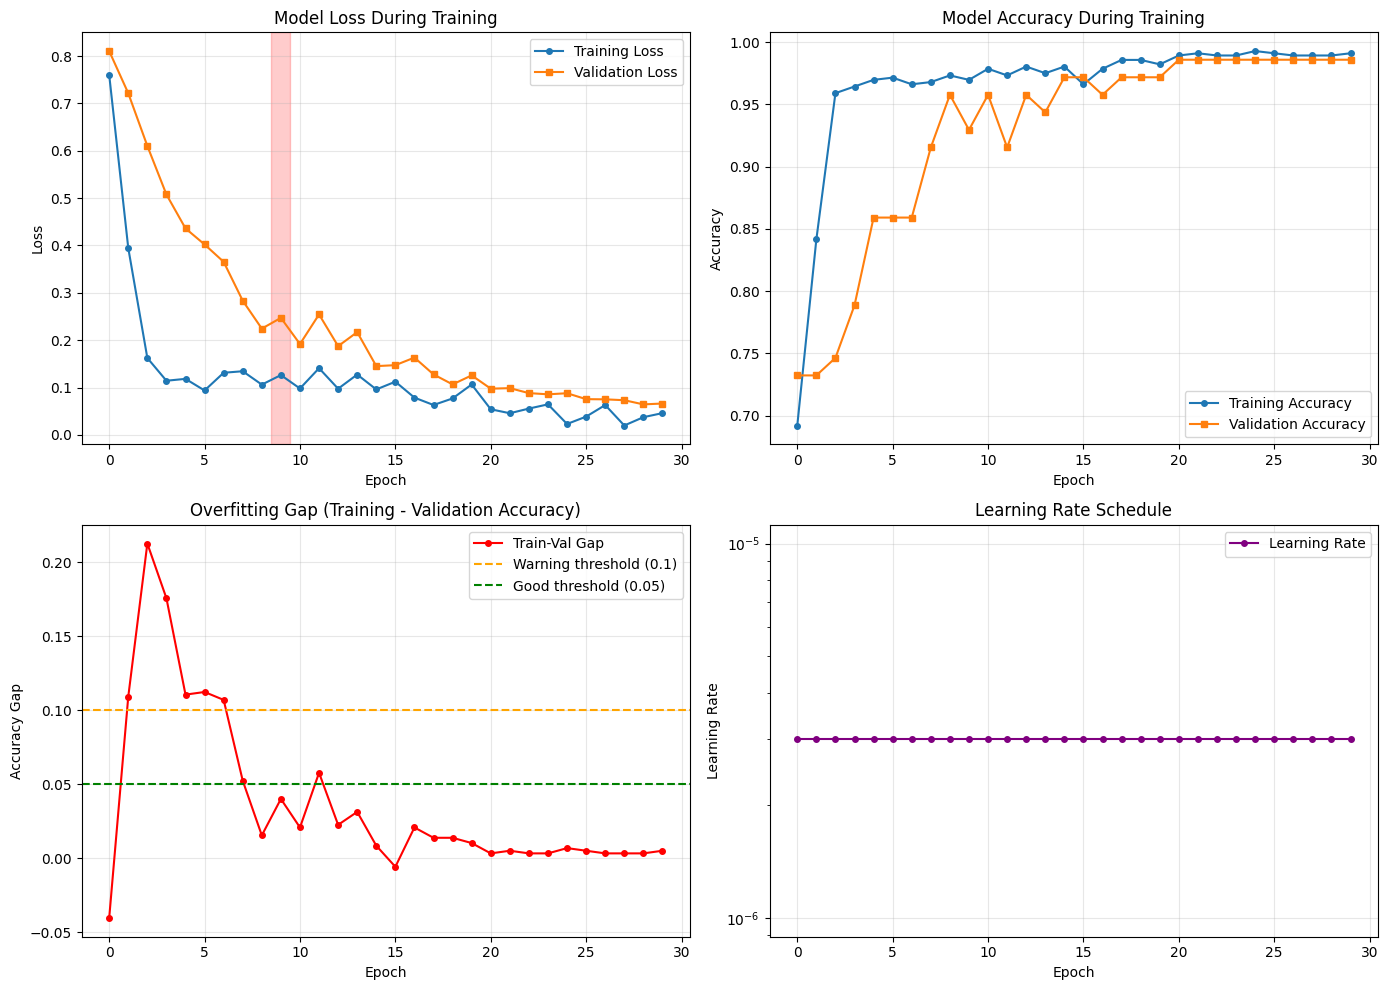


Detailed Overfitting Analysis:
Best epoch: 21
Best validation accuracy: 0.9859
Training accuracy at best epoch: 0.9893
Overfitting gap at best epoch: 0.0034

Validation loss started increasing at epoch 10

Loss Analysis:
Final training loss: 0.0461
Final validation loss: 0.0664
Loss ratio (val/train): 1.44
✓ Acceptable loss ratio


In [13]:
# Plot comprehensive training history
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss plot
ax1 = axes[0, 0]
ax1.plot(history['train_loss'], label='Training Loss', marker='o', markersize=4)
ax1.plot(history['val_loss'], label='Validation Loss', marker='s', markersize=4)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Model Loss During Training')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add overfitting region
if len(history['train_loss']) > 1:
    for i in range(1, len(history['train_loss'])):
        if history['val_loss'][i] > history['val_loss'][i-1] * 1.1:  # 10% increase
            ax1.axvspan(i-0.5, i+0.5, alpha=0.2, color='red', label='Overfitting')
            break

# Accuracy plot
ax2 = axes[0, 1]
ax2.plot(history['train_acc'], label='Training Accuracy', marker='o', markersize=4)
ax2.plot(history['val_acc'], label='Validation Accuracy', marker='s', markersize=4)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Model Accuracy During Training')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Overfitting gap plot
ax3 = axes[1, 0]
overfitting_gap = [t - v for t, v in zip(history['train_acc'], history['val_acc'])]
ax3.plot(overfitting_gap, label='Train-Val Gap', marker='o', color='red', markersize=4)
ax3.axhline(y=0.1, color='orange', linestyle='--', label='Warning threshold (0.1)')
ax3.axhline(y=0.05, color='green', linestyle='--', label='Good threshold (0.05)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy Gap')
ax3.set_title('Overfitting Gap (Training - Validation Accuracy)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Learning rate plot
ax4 = axes[1, 1]
ax4.plot(history['lr'], label='Learning Rate', marker='o', color='purple', markersize=4)
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Learning Rate')
ax4.set_title('Learning Rate Schedule')
ax4.set_yscale('log')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed overfitting analysis
print("\nDetailed Overfitting Analysis:")
print("="*60)

# Find best epoch
best_epoch = history['val_acc'].index(max(history['val_acc']))
print(f"Best epoch: {best_epoch + 1}")
print(f"Best validation accuracy: {history['val_acc'][best_epoch]:.4f}")
print(f"Training accuracy at best epoch: {history['train_acc'][best_epoch]:.4f}")
print(f"Overfitting gap at best epoch: {history['train_acc'][best_epoch] - history['val_acc'][best_epoch]:.4f}")

# Check if model started overfitting
overfitting_started = False
for i in range(1, len(history['val_loss'])):
    if history['val_loss'][i] > history['val_loss'][i-1]:
        print(f"\nValidation loss started increasing at epoch {i+1}")
        overfitting_started = True
        break

if not overfitting_started:
    print("\n✓ No clear overfitting detected - validation loss consistently decreased")

# Loss behavior analysis
final_train_loss = history['train_loss'][-1]
final_val_loss = history['val_loss'][-1]
loss_ratio = final_val_loss / final_train_loss

print(f"\nLoss Analysis:")
print(f"Final training loss: {final_train_loss:.4f}")
print(f"Final validation loss: {final_val_loss:.4f}")
print(f"Loss ratio (val/train): {loss_ratio:.2f}")

if loss_ratio > 2:
    print("⚠️ High loss ratio indicates significant overfitting")
elif loss_ratio > 1.5:
    print("⚠️ Moderate loss ratio - some overfitting present")
else:
    print("✓ Acceptable loss ratio")

In [14]:
# Evaluation on test set (only done once at the end)
model.eval()
mental_bert_predictions = []
mental_bert_probabilities = []

print("\nEvaluating Mental-BERT model on test set...")
with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)
        probs = torch.softmax(outputs.logits, dim=-1)[:, 1]  # Probability of class 1 (ASD)
        
        mental_bert_predictions.extend(predictions.cpu().numpy())
        mental_bert_probabilities.extend(probs.cpu().numpy())

mental_bert_predictions = np.array(mental_bert_predictions)
mental_bert_probabilities = np.array(mental_bert_probabilities)

print("\nMental-BERT Test Set Results:")
print(classification_report(y_test, mental_bert_predictions, target_names=['NO ASD', 'ASD']))
mental_bert_accuracy = accuracy_score(y_test, mental_bert_predictions)
print(f"Mental-BERT Test Accuracy: {mental_bert_accuracy:.3f}")

# For backward compatibility
bert_predictions = mental_bert_predictions
bert_probabilities = mental_bert_probabilities
bert_accuracy = mental_bert_accuracy


Evaluating Mental-BERT model on test set...


100%|██████████| 9/9 [00:00<00:00, 17.86it/s]


Mental-BERT Test Set Results:
              precision    recall  f1-score   support

      NO ASD       0.95      1.00      0.97        52
         ASD       1.00      0.84      0.91        19

    accuracy                           0.96        71
   macro avg       0.97      0.92      0.94        71
weighted avg       0.96      0.96      0.96        71

Mental-BERT Test Accuracy: 0.958


In [15]:
# AQ-10 threshold classification (score >= 6 indicates ASD)
aq10_predictions = (aq10_test >= 6).astype(int)

print("\nAQ-10 Threshold (≥6) Results:")
print(classification_report(y_test, aq10_predictions, target_names=['NO ASD', 'ASD']))

# Calculate accuracies for comparison
aq10_accuracy = accuracy_score(y_test, aq10_predictions)

print(f"\nAccuracy Comparison:")
print(f"Mental-BERT Model: {mental_bert_accuracy:.3f}")
print(f"AQ-10 Threshold: {aq10_accuracy:.3f}")

# Compare all three sets performance
print(f"\nPerformance Summary:")
print(f"Training Accuracy: {history['train_acc'][-1]:.3f}")
print(f"Validation Accuracy: {history['val_acc'][-1]:.3f}")
print(f"Test Accuracy: {mental_bert_accuracy:.3f}")


AQ-10 Threshold (≥6) Results:
              precision    recall  f1-score   support

      NO ASD       1.00      0.87      0.93        52
         ASD       0.73      1.00      0.84        19

    accuracy                           0.90        71
   macro avg       0.87      0.93      0.89        71
weighted avg       0.93      0.90      0.91        71


Accuracy Comparison:
Mental-BERT Model: 0.958
AQ-10 Threshold: 0.901

Performance Summary:
Training Accuracy: 0.991
Validation Accuracy: 0.986
Test Accuracy: 0.958


In [ ]:
# Import required functions
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set consistent style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Define consistent colors
COLOR_TRAIN = '#2E86AB'
COLOR_VAL = '#A23B72'
COLOR_MENTAL_BERT = '#F18F01'
COLOR_AQ10 = '#C73E1D'
COLOR_HIGH_RISK = '#FF6B6B'
COLOR_MEDIUM_RISK = '#FFE66D'
COLOR_LOW_RISK = '#4ECDC4'

Generating Figure 1: Training and Validation Curves...


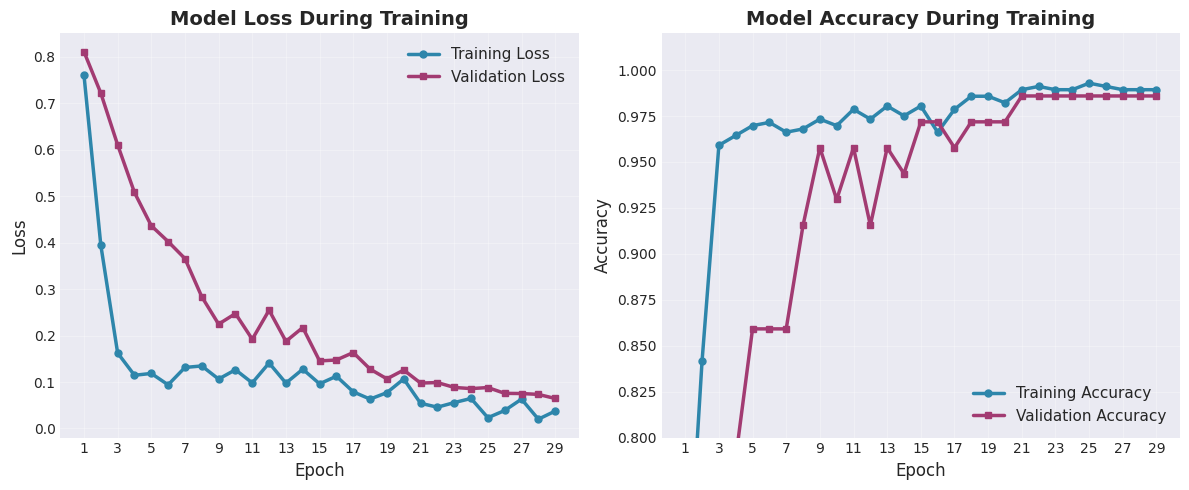


Generating Figure 2: Confusion Matrix...


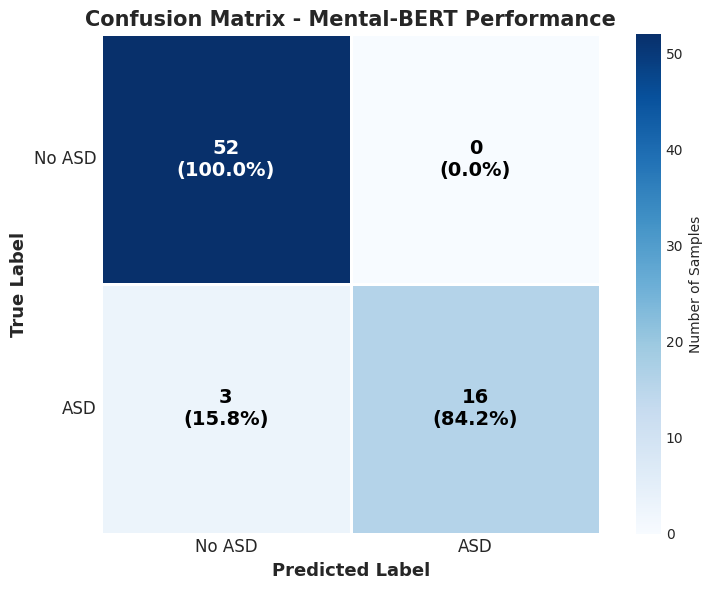


Generating Figure 3: Performance Comparison...


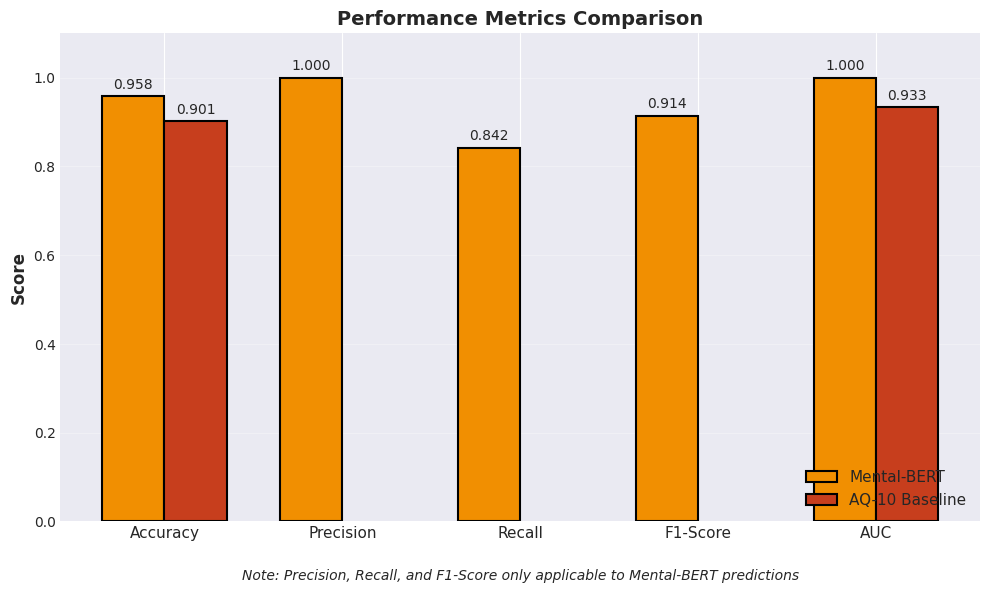


Generating Figure 4: ROC Curves...


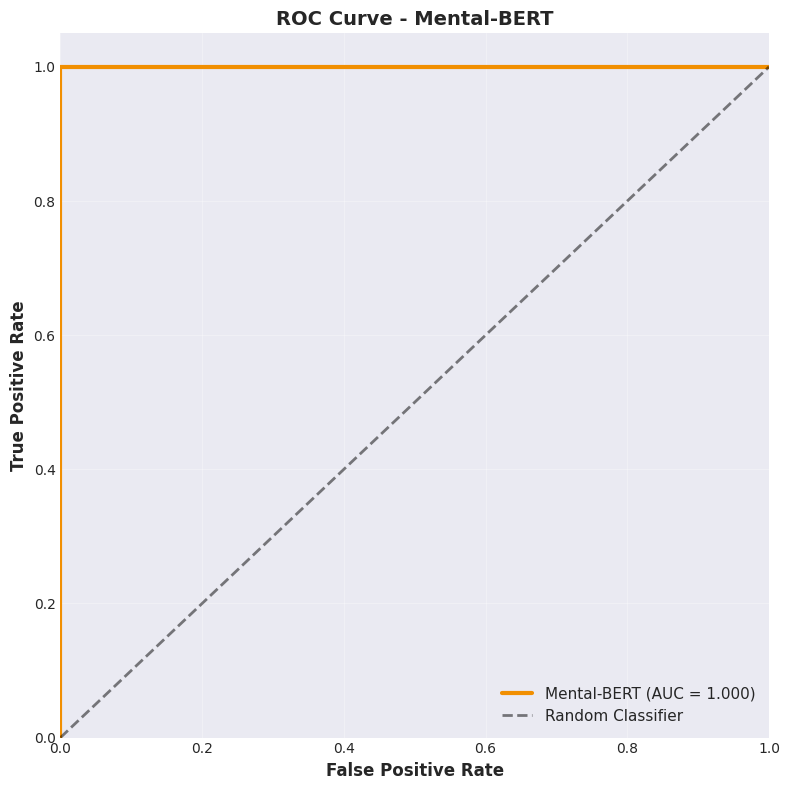

In [39]:

history = json.load(open("outputs/history.json"))

# Figure 1: Training and Validation Curves

def create_training_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)
    train_loss = history['train_loss']
    val_loss = history['val_loss']
    train_acc = history['train_acc']
    val_acc = history['val_acc']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Loss curves
    ax1.plot(epochs, train_loss, 'o-', color=COLOR_TRAIN, linewidth=2.5, 
             markersize=5, label='Training Loss')
    ax1.plot(epochs, val_loss, 's-', color=COLOR_VAL, linewidth=2.5, 
             markersize=5, label='Validation Loss')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Model Loss During Training', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper right', fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(list(epochs)[::max(1, len(epochs)//10)])  # Fewer ticks if many epochs
    
    # Accuracy curves
    ax2.plot(epochs, train_acc, 'o-', color=COLOR_TRAIN, linewidth=2.5, 
             markersize=5, label='Training Accuracy')
    ax2.plot(epochs, val_acc, 's-', color=COLOR_VAL, linewidth=2.5, 
             markersize=5, label='Validation Accuracy')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title('Model Accuracy During Training', fontsize=14, fontweight='bold')
    ax2.legend(loc='lower right', fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(list(epochs)[::max(1, len(epochs)//10)])
    ax2.set_ylim(0.8, 1.02)

    plt.tight_layout()
    plt.savefig('figure1_training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()


#Fig2 - CONFUSION MATRIX
def create_confusion_matrix(y_true, y_pred, class_names=None, filename="figure2_confusion_matrix.png"):
    """
    y_true: true labels (array-like)
    y_pred: predicted labels (array-like)
    class_names: list of class names for axis ticks (optional)
    """
    cm = confusion_matrix(y_true, y_pred)
    n_classes = cm.shape[0]
    
    fig, ax = plt.subplots(figsize=(6 + n_classes, 6))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=True,
                square=True, linewidths=2, linecolor='white',
                cbar_kws={'label': 'Number of Samples'})
    
    # Annotate counts and percentages (row-normalized, i.e. % of true label)
    row_sums = cm.sum(axis=1, keepdims=True)
    for i in range(n_classes):
        for j in range(n_classes):
            pct = (cm[i, j] / row_sums[i, 0] * 100) if row_sums[i, 0] > 0 else 0
            text = f'{cm[i, j]}\n({pct:.1f}%)'
            ax.text(j + 0.5, i + 0.5, text, ha='center', va='center',
                    fontsize=14, fontweight='bold',
                    color='white' if cm[i, j] > row_sums.max() * 0.4 else 'black')
    
    # Labels
    ax.set_xlabel('Predicted Label', fontsize=13, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=13, fontweight='bold')
    ax.set_title('Confusion Matrix - Mental-BERT Performance', fontsize=15, fontweight='bold')
    
    # Set tick labels
    if class_names is None:
        class_names = [f"Class {i}" for i in range(n_classes)]
    ax.set_xticklabels(class_names, fontsize=12)
    ax.set_yticklabels(class_names, fontsize=12, rotation=0)
    
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()



# Figure 3: Performance Comparison
def create_performance_comparison(
    mental_bert_metrics, 
    aq10_metrics, 
    metrics_labels=None, 
    filename="figure3_performance_comparison.png"
):
    """
    mental_bert_metrics: list of values [accuracy, precision, recall, f1, auc]
    aq10_metrics: list of values [accuracy, precision, recall, f1, auc] (use np.nan for N/A)
    metrics_labels: optional, names for the metrics
    """
    if metrics_labels is None:
        metrics_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
    x = np.arange(len(metrics_labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))

    # Create bars
    bars1 = ax.bar(x - width/2, mental_bert_metrics, width, label='Mental-BERT', 
                   color=COLOR_MENTAL_BERT, edgecolor='black', linewidth=1.5)
    bars2 = ax.bar(x + width/2, aq10_metrics, width, label='AQ-10 Baseline', 
                   color=COLOR_AQ10, edgecolor='black', linewidth=1.5)

    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if not np.isnan(height):
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{height:.3f}', ha='center', va='bottom', fontsize=10)

    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_labels, fontsize=11)
    ax.legend(loc='lower right', fontsize=11)
    ax.set_ylim(0, 1.1)
    ax.grid(True, alpha=0.3, axis='y')

    ax.text(0.5, -0.12, 'Note: Precision, Recall, and F1-Score only applicable to Mental-BERT predictions', 
            transform=ax.transAxes, ha='center', fontsize=10, style='italic')

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

# Figure 4: ROC Curves
def create_roc_curves(y_true, mb_probs, filename="figure4_roc_curves.png"):
    """
    y_true: true test labels (array-like)
    mb_probs: probabilities from Mental-BERT (positive class)
    """
    fpr_mb, tpr_mb, _ = roc_curve(y_true, mb_probs)
    roc_auc_mb = auc(fpr_mb, tpr_mb)

    fig, ax = plt.subplots(figsize=(8, 8))

    ax.plot(fpr_mb, tpr_mb, color=COLOR_MENTAL_BERT, linewidth=3,
            label=f'Mental-BERT (AUC = {roc_auc_mb:.3f})')
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=2, label='Random Classifier')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    ax.set_title('ROC Curve - Mental-BERT', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right', fontsize=11)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


if __name__ == "__main__":
    print("Generating Figure 1: Training and Validation Curves...")
    create_training_curves(history)
    
    print("\nGenerating Figure 2: Confusion Matrix...")
    create_confusion_matrix(y_test, mental_bert_predictions, class_names=["No ASD", "ASD"])

    
    print("\nGenerating Figure 3: Performance Comparison...")
    create_performance_comparison(
    [mental_bert_accuracy, precision, recall, f1, roc_auc_bert],
    [aq10_accuracy, np.nan, np.nan, np.nan, roc_auc_aq10]
    )
    
    print("\nGenerating Figure 4: ROC Curves...")
    create_roc_curves(y_test, mental_bert_probs)
    

In [17]:
def predict_asd_risk(narrative, aq10_score, model, tokenizer, device):
    """
    Predict ASD risk based on narrative and AQ-10 score
    Returns: risk level (Low, Medium, High) and recommendation
    """
    # Tokenize the narrative
    inputs = tokenizer(narrative, return_tensors="pt", padding="max_length", 
                      truncation=True, max_length=512)
    
    # Move to device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Get prediction
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1)
        narrative_pred = torch.argmax(outputs.logits, dim=-1).item()
        narrative_prob = probs[0, 1].item()  # Probability of ASD
    
    # Combine with AQ-10 score
    aq10_risk = aq10_score >= 6
    
    # Decision logic
    if narrative_pred == 1 and aq10_risk:
        risk_level = "HIGH"
        recommendation = "Strongly recommend comprehensive ASD assessment"
    elif narrative_pred == 1 or aq10_risk:
        risk_level = "MEDIUM"
        recommendation = "Consider ASD assessment, monitor symptoms"
    else:
        risk_level = "LOW"
        recommendation = "No immediate ASD assessment needed"
    
    return {
        'risk_level': risk_level,
        'narrative_indicates_asd': bool(narrative_pred),
        'narrative_confidence': narrative_prob,
        'aq10_indicates_asd': aq10_risk,
        'aq10_score': aq10_score,
        'recommendation': recommendation
    }

# Test the combined system on test set examples
print("Example predictions from test set:")
for i in range(min(5, len(X_test))):
    result = predict_asd_risk(X_test[i], aq10_test[i], model, tokenizer, device)
    print(f"\nPatient {i+1}:")
    print(f"  Narrative: {X_test[i][:150]}...")
    print(f"  Actual diagnosis: {'ASD' if y_test[i] == 1 else 'No ASD'}")
    print(f"  Risk level: {result['risk_level']}")
    print(f"  Narrative indicates ASD: {result['narrative_indicates_asd']} (confidence: {result['narrative_confidence']:.3f})")
    print(f"  AQ-10 score: {result['aq10_score']} (indicates ASD: {result['aq10_indicates_asd']})")
    print(f"  Recommendation: {result['recommendation']}")

Example predictions from test set:

Patient 1:
  Narrative: Even when a room seems quiet to everyone else, I can still hear things like the fluorescent lights buzzing. These sounds constantly pull my attention ...
  Actual diagnosis: No ASD
  Risk level: LOW
  Narrative indicates ASD: False (confidence: 0.110)
  AQ-10 score: 3.0 (indicates ASD: False)
  Recommendation: No immediate ASD assessment needed

Patient 2:
  Narrative: In my experience, multitasking is something I really struggle with. Even trying to follow a conversation while shopping can make me feel overloaded. I...
  Actual diagnosis: No ASD
  Risk level: LOW
  Narrative indicates ASD: False (confidence: 0.042)
  AQ-10 score: 3.0 (indicates ASD: False)
  Recommendation: No immediate ASD assessment needed

Patient 3:
  Narrative: In my experience, i often struggle with indirect communication. Sarcasm, jokes with hidden meanings, or subtle hints are things I tend to miss entirel...
  Actual diagnosis: No ASD
  Risk level: L

In [18]:
# Save the Mental-BERT model
model_save_path = "./mental_bert_asd_model_with_validationv3"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Mental-BERT model saved to {model_save_path}")

# Save training history
import json
with open(f"{model_save_path}/training_history.json", 'w') as f:
    json.dump(history, f)

# Save split information
split_info = {
    'total_samples': len(X),
    'train_samples': len(X_train),
    'val_samples': len(X_val),
    'test_samples': len(X_test),
    'train_percentage': len(X_train)/len(X)*100,
    'val_percentage': len(X_val)/len(X)*100,
    'test_percentage': len(X_test)/len(X)*100,
    'best_val_accuracy': float(best_val_accuracy),
    'test_accuracy': float(mental_bert_accuracy)
}

with open(f"{model_save_path}/split_info.json", 'w') as f:
    json.dump(split_info, f, indent=2)

print("\nModel and training information saved successfully!")


Mental-BERT model saved to ./mental_bert_asd_model_with_validationv3

Model and training information saved successfully!


In [26]:
import numpy as np
import torch

model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels']
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        # For binary: probs = torch.softmax(logits, dim=1)[:, 1]
        # For multiclass: get the probability for your class of interest, e.g., class 1
        probs = torch.softmax(logits, dim=1)[:, 1]  # Use [:,1] for class 1 (edit if needed)
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.numpy())

mental_bert_probs = np.array(all_probs)
y_test = np.array(all_labels)

In [28]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

# Use your original predictions for these:
precision, recall, f1, support = precision_recall_fscore_support(y_test, mental_bert_predictions, average='binary')

# For ROC-AUC, use probabilities!
roc_auc_bert = roc_auc_score(y_test, mental_bert_probs)  # ← Use probs, not predictions
roc_auc_aq10 = roc_auc_score(y_test, aq10_predictions)

print("\nFinal Model Performance Summary:")
print("="*60)
print(f"Mental-BERT Model Performance:")
print(f"  - Best Validation Accuracy: {best_val_accuracy:.3f}")
print(f"  - Test Accuracy: {mental_bert_accuracy:.3f}")
print(f"  - Precision: {precision:.3f}")
print(f"  - Recall: {recall:.3f}")
print(f"  - F1-Score: {f1:.3f}")
print(f"  - AUC: {roc_auc_bert:.3f}")

print(f"\nAQ-10 Baseline:")
print(f"  - Accuracy: {aq10_accuracy:.3f}")
print(f"  - AUC: {roc_auc_aq10:.3f}")

# Performance improvement
improvement = ((mental_bert_accuracy - aq10_accuracy) / aq10_accuracy) * 100
print(f"\nMental-BERT improvement over AQ-10: {improvement:.1f}%")

# Generalization assessment
val_test_gap = abs(best_val_accuracy - mental_bert_accuracy)
print(f"\nGeneralization Assessment:")
print(f"Validation-Test Gap: {val_test_gap:.3f}")
if val_test_gap < 0.05:
    print("✓ Excellent generalization - validation and test performance are very close")
elif val_test_gap < 0.1:
    print("✓ Good generalization - minor difference between validation and test")
else:
    print("⚠️ Potential generalization issue - significant gap between validation and test")

print("\n" + "="*60)
print("Training Complete!")
print("="*60)


Final Model Performance Summary:
Mental-BERT Model Performance:
  - Best Validation Accuracy: 0.986
  - Test Accuracy: 0.958
  - Precision: 1.000
  - Recall: 0.842
  - F1-Score: 0.914
  - AUC: 1.000

AQ-10 Baseline:
  - Accuracy: 0.901
  - AUC: 0.933

Mental-BERT improvement over AQ-10: 6.2%

Generalization Assessment:
Validation-Test Gap: 0.028
✓ Excellent generalization - validation and test performance are very close

Training Complete!


In [ ]:
#Using the Model with New Data
#Load the saved model and tokenizer
model_save_path = "./bert_asd_model"
loaded_model = AutoModelForSequenceClassification.from_pretrained(model_save_path)
loaded_tokenizer = AutoTokenizer.from_pretrained(model_save_path)
loaded_model.to(device)
loaded_model.eval()

print("Model loaded successfully!")

In [ ]:
#Single Patient Prediction

def predict_single_patient(narrative, aq10_score, model, tokenizer, device):
    """
    Make prediction for a single new patient
    """
    # Tokenize the narrative
    inputs = tokenizer(narrative, return_tensors="pt", padding="max_length", 
                      truncation=True, max_length=512)
    
    # Move to device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Get prediction
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1)
        prediction = torch.argmax(outputs.logits, dim=-1).item()
        confidence = probs[0, prediction].item()
        asd_probability = probs[0, 1].item()
    
    # Combine with AQ-10 score
    aq10_indicates_asd = aq10_score >= 6
    
    # Determine risk level
    if prediction == 1 and aq10_indicates_asd:
        risk_level = "HIGH"
        recommendation = "Strongly recommend comprehensive ASD assessment"
    elif prediction == 1 or aq10_indicates_asd:
        risk_level = "MEDIUM"
        recommendation = "Consider ASD assessment, monitor symptoms"
    else:
        risk_level = "LOW"
        recommendation = "No immediate ASD assessment needed"
    
    result = {
        'narrative_prediction': 'ASD' if prediction == 1 else 'No ASD',
        'narrative_confidence': confidence,
        'asd_probability': asd_probability,
        'aq10_score': aq10_score,
        'aq10_indicates_asd': aq10_indicates_asd,
        'risk_level': risk_level,
        'recommendation': recommendation
    }
    
    return result

result = predict_single_patient(new_narrative, new_aq10_score, loaded_model, loaded_tokenizer, device)

print("New Patient Assessment:")
print(f"Narrative indicates: {result['narrative_prediction']} (confidence: {result['narrative_confidence']:.2%})")
print(f"ASD probability: {result['asd_probability']:.2%}")
print(f"AQ-10 score: {result['aq10_score']} (indicates ASD: {result['aq10_indicates_asd']})")
print(f"Risk level: {result['risk_level']}")
print(f"Recommendation: {result['recommendation']}")
